In [1]:
# Import modules
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
pd.options.display.max_columns = 300
sns.set_style('darkgrid')

In [2]:
# Connect to PostgreSQL
conn = psycopg2.connect(database='usaspending', user='team', password='ZAQ!@#zaq123', host='dopelytics.site', port='5432')

### Initialize data set

In [3]:
# Select data elements 
sql_cols = ('federal_action_obligation, '
            #'total_dollars_obligated, '
            'base_and_exercised_options_value, '
            'base_and_all_options_value, '
            #'awarding_sub_agency_name, '
            'awarding_sub_agency_code, '
            #'awarding_office_name, '
            'awarding_office_code, '
            #'funding_sub_agency_name, '
            'funding_sub_agency_code, '
            #'funding_office_name, '  too many NaN
            'primary_place_of_performance_state_code, '
            'award_or_idv_flag, '
            #'award_type, '
            'award_type_code, '
            #'type_of_contract_pricing, '
            'type_of_contract_pricing_code, '
            #'dod_claimant_program_description, '
            'dod_claimant_program_code, '
            'type_of_set_aside_code, '
            #'multi_year_contract, ' too many NaN
            #'dod_acquisition_program_description, ' too many NaN
            #'subcontracting_plan, ' too many NaN
            #'contract_bundling, '
            'contract_bundling_code, '
            #'evaluated_preference, ' too many NaN
            #'national_interest_action, '
            'national_interest_action_code, '
            #'cost_or_pricing_data, ' too many NaN
            #'gfe_gfp, '
            'gfe_gfp_code, '
            #'contract_financing, '
            'contract_financing_code, '
            'portfolio_group, '
            #'product_or_service_code_description, '
            'product_or_service_code, '
            #'naics_bucket_title, ' too many NaN
            #'naics_description'
            'naics_code'
            )

# Create dataframe
sql_tbl_name = 'consolidated_data2'
df = pd.read_sql_query('SELECT ' + sql_cols + ' FROM ' + sql_tbl_name, con=conn)
print('Shape of initial df:', df.shape)

# Drop rows with NaN values
df = df.dropna()
print('Shape with no NaN values:', df.shape)

Shape of initial df: (272790, 19)
Shape with no NaN values: (270531, 19)


## ONLY For Predicting Future Years
#### The following code should only be ran for training on 2015-2016 and applying to 2017 data

In [ ]:
# Create dataframe
sql_tbl_name = 'data_2017'
df2 = pd.read_sql_query('SELECT ' + sql_cols + ' FROM ' + sql_tbl_name, con=conn)
print('Shape of initial df:', df2.shape)

# Drop rows with NaN values
df2 = df2.dropna()
print('Shape with no NaN values:', df2.shape)

# Set matching features and 2015-2016 and 2017 data sets
headers = list(df.columns)
keys = headers
i1 = df.set_index(keys).index
i2 = df2.set_index(keys).index
df = df[i1.isin(i2)]
df2 = df2[i2.isin(i1)]

#### BREAK -- proceed to following code

In [4]:
# Create two columns for set-aside (0/1) and contract value

def set_aside(c):
    if c['type_of_set_aside_code'] == 'NONE':
        return 0
    else:
        return 1

def contract_value(c):
    if c['base_and_exercised_options_value'] > 0:
        return c['base_and_exercised_options_value']
    elif c['base_and_all_options_value'] > 0:
        return c['base_and_all_options_value']
    elif c['federal_action_obligation'] > 0:
        return c['federal_action_obligation'] 
    else:
        return 0

df['set_aside'] = df.apply(set_aside, axis=1)
df['contract_value'] = df.apply(contract_value, axis=1)

# Drop columns that are no longer needed
df = df.drop(['type_of_set_aside_code','base_and_exercised_options_value','base_and_all_options_value',
              'federal_action_obligation'], axis=1)

## Feature Selection
#### Initialize Model

In [38]:
# Create feature and target dataframes
X_int = df.drop(['set_aside'], axis = 1)
y = df['set_aside']

# One hot encoding for features
X_int = pd.get_dummies(X_int)
print('Shape of OHE feature df:', X_int.shape)

Shape of OHE feature df: (270531, 3394)


In [39]:
# Import Random Forest Classifier modules
from sklearn.model_selection import train_test_split, cross_val_score
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier

In [40]:
# Fit initial model
X_train, X_test, y_train, y_test = train_test_split(X_int, y, test_size=0.20, random_state=42)
model = RandomForestClassifier(n_estimators=17, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)
print('Model Accuracy: {:.2%}'.format(model.score(X_test, y_test)))

Model Accuracy: 91.40%


#### Find Important Features

In [41]:
# Calcultae feature importance
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
# Sort descending important features...
# Calculate cumalative percentage of total importance...
# Only keep features accounting for top 80% of feature importance
feature_importances['cumpercent'] = feature_importances['importance'].cumsum()/feature_importances['importance'].sum()*100
relevant_features = feature_importances[feature_importances.cumpercent < 80]
print('Shape of relevant features:', relevant_features.shape)

# Create list of relevant features to create new dataframe with only relevant features
list_relevant_features = list(relevant_features.index)

X = X_int[list_relevant_features]
print('Shape of initialized feature dataframe X with only relevant features:', X.shape)

Shape of relevant features: (317, 2)
Shape of initialized feature dataframe X with only relevant features: (270531, 317)


In [42]:
relevant_features

,importance,cumpercent
contract_value,0.122387,12.238687
dod_claimant_program_description_CONSTRUCTION,0.025552,14.793847
naics_description_COMMERCIAL AND INSTITUTIONAL BUILDING CONSTRUCTION,0.022363,17.030153
portfolio_group_Electronic & Communication Services,0.013235,18.353668
portfolio_group_Facility Related Services,0.012115,19.565138
...,...,...
product_or_service_code_description_R&D- DEFENSE SYSTEM: ELECTRONICS/COMMUNICATION EQUIPMENT (APPLIED RESEARCH/EXPLORATORY DEVELOPMENT),0.000525,79.751213
contract_financing_PERFORMANCE-BASED FINANCING,0.000524,79.803645
naics_description_SITE PREPARATION CONTRACTORS,0.000523,79.855945
product_or_service_code_description_MAINTENANCE OF OTHER NON-BUILDING FACILITIES,0.000522,79.908170


In [43]:
# Test accuracy of initialized dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = RandomForestClassifier(n_estimators=17, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)
print('Model Accuracy: {:.2%}'.format(model.score(X_test, y_test)))

Model Accuracy: 90.47%


## Perform Random Forest Classification
#### Using only relevant features dataframe

In [56]:
predictions = model.predict(X_test)

In [57]:
classes = ['None', 'Set Aside']

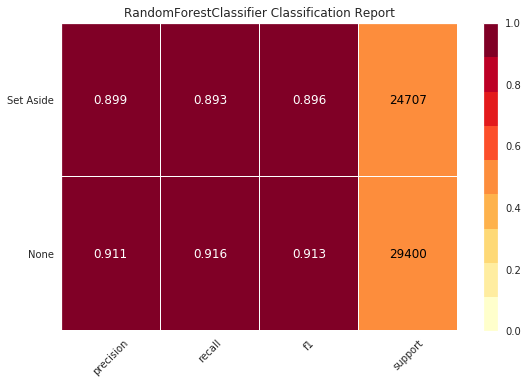

In [58]:
visualizer = ClassificationReport(model, classes=classes, support=True)
visualizer.score(X_test, y_test)
visualizer.show()

In [59]:
model_score = cross_val_score(estimator=model, X=X, y=y, scoring='f1', cv=12)

In [60]:
print("Accuracy : ", round(model_score.mean(),2))
print('Standard Deviation : ',round(model_score.std(),2))

Accuracy :  0.9
Standard Deviation :  0.06


In [90]:
import pickle

In [92]:
#Save Trained Model
filename = 'RandomForest_SetAside_None_Model.save'
pickle.dump(model, open(filename, 'wb'))

## Perform Second Model - Predict Type of Set-Aside

In [104]:
df1 = pd.read_sql_query('SELECT ' + sql_cols + ' FROM ' + sql_tbl_name, con=conn)
print('Shape of initial df:', df1.shape)

Shape of initial df: (272790, 19)


In [105]:
# Drop all instances where type_of_set_aside_code = NONE
none_set_asides = df1[df1['type_of_set_aside_code'] == 'NONE'].index
df1 = df1.drop(none_set_asides, axis=0)
print('Shape of dataframe WITH set-asides:', df1.shape)

Shape of dataframe WITH set-asides: (124990, 19)


In [106]:
# Create column for contract value

def contract_value(c):
    if c['base_and_exercised_options_value'] > 0:
        return c['base_and_exercised_options_value']
    elif c['base_and_all_options_value'] > 0:
        return c['base_and_all_options_value']
    elif c['federal_action_obligation'] > 0:
        return c['federal_action_obligation'] 
    else:
        return 0
    
df1['contract_value'] = df1.apply(contract_value, axis=1)

# Assign numerics to set-aside codes
df1['set_aside_number'] = df1['type_of_set_aside_code'].map({'SBA':1, '8AN':2, '8A':3, 'SDVOSBC':4,'HZC':5, 'WOSB':6, 
                                                             'SBP':7, 'EDWOSB':7, 'SDVOSBS':7, 'HZS':7, 'WOSBSS':7, 
                                                             'EDWOSBSS':7, 'ISBEE':7, 'HS3':7, 'IEE':7})

# Drop columns that are no longer needed
df1 = df1.drop(['type_of_set_aside_code','base_and_exercised_options_value','base_and_all_options_value',
             'federal_action_obligation'], axis=1)

df1 = df1.dropna()
print('Shape of dataframe WITH set-asides with no NaN values:', df1.shape)

Shape of dataframe WITH set-asides with no NaN values: (123169, 17)


In [108]:
X1 = df1.drop(['set_aside_number'], axis=1).copy()
print('Shape of originial X1 dataframe:', X1.shape)

# One hot encoding
X1 = pd.get_dummies(X1)

# Create a list of relevant features in X1 based on the list of previous relevant features from feature selection
# Note numpy is taking only relevant features from the first feature selection that are also in X1
cols = list(X1.columns)
updated_list_relevant_features = np.asarray(list_relevant_features)[np.in1d(list_relevant_features, cols)].tolist()

# Updated dummy table with only relevant features
X1 = X1[updated_list_relevant_features]
print('Shape of X1 dummy dataframe:', X1.shape)

Shape of originial X1 dataframe: (123169, 16)
Shape of X1 dummy dataframe: (123169, 313)


In [109]:
y1 = df1['set_aside_number'].copy()

In [110]:
y1.value_counts()

1.0    76868
2.0    19629
3.0    15205
4.0     4153
5.0     3833
6.0     1997
7.0     1484
Name: set_aside_number, dtype: int64

In [111]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=42)

In [112]:
model1 = RandomForestClassifier(n_estimators=17)

In [113]:
model1.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=17,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [114]:
classes1 = ['SBA', '8AN', '8A', 'SDVOSBC','HZC', 'WOSB', 'OTHER SET ASIDE']

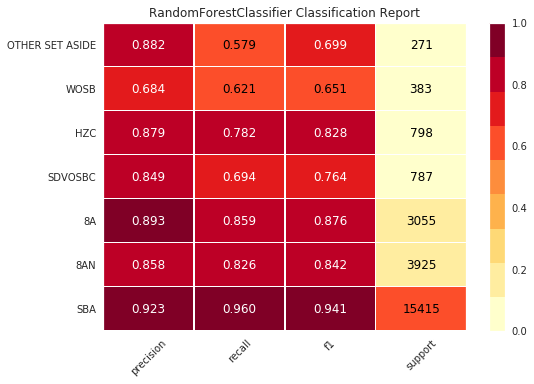

In [115]:
visualizer = ClassificationReport(model1, classes=classes1, support=True)
visualizer.score(X1_test, y1_test)
visualizer.show()

In [116]:
model_score_all_set_aside = cross_val_score(estimator=model, X=X1, y=y1, scoring='f1_weighted', cv=12)

In [117]:
print("Accuracy : ", round(model_score_all_set_aside.mean(),2))
print('Standard Deviation : ',round(model_score_all_set_aside.std(),2))

Accuracy :  0.9
Standard Deviation :  0.05


In [93]:
#Save Trained Model
filename = 'RandomForest_All_Set_Aside_Model.save'
pickle.dump(model, open(filename, 'wb'))

## Test the Model on 2017 Data

In [ ]:
# Create column for contract value

def contract_value(c):
    if c['base_and_exercised_options_value'] > 0:
        return c['base_and_exercised_options_value']
    elif c['base_and_all_options_value'] > 0:
        return c['base_and_all_options_value']
    elif c['federal_action_obligation'] > 0:
        return c['federal_action_obligation'] 
    else:
        return 0
    
df2['contract_value'] = df2.apply(contract_value, axis=1)

# Assign numerics to set-aside codes
df2['set_aside_number'] = df2['type_of_set_aside_code'].map({'SBA':1, '8AN':2, '8A':3, 'SDVOSBC':4,'HZC':5, 'WOSB':6, 
                                                             'SBP':7, 'EDWOSB':7, 'SDVOSBS':7, 'HZS':7, 'WOSBSS':7, 
                                                             'EDWOSBSS':7, 'ISBEE':7, 'HS3':7, 'IEE':7})

# Drop columns that are no longer needed
df2 = df2.drop(['type_of_set_aside_code','base_and_exercised_options_value','base_and_all_options_value',
             'federal_action_obligation'], axis=1)

df2 = df2.dropna()
print('Shape of dataframe WITH set-asides with no NaN values:', df2.shape)

In [ ]:
X2 = df2.drop(['set_aside_number'], axis=1).copy()
print('Shape of originial X2 dataframe:', X2.shape)

# One hot encoding
X2 = pd.get_dummies(X2)

# Updated dummy table with only relevant features
X2 = X2[updated_list_relevant_features]
print('Shape of X2 dummy dataframe:', X2.shape)

y2 = df2['set_aside_number'].copy()

In [ ]:
visualizer.score(X2_test, y2_test)
visualizer.show()

In [ ]:
model_score_all_set_aside = cross_val_score(estimator=model, X=X1, y=y1, scoring='f1_weighted', cv=12)
print("Accuracy : ", round(model_score_all_set_aside.mean(),2))
print('Standard Deviation : ',round(model_score_all_set_aside.std(),2))